## Table of Content
> **Introduction** <br/><br/>
> **Scenario Experiment & Reading The Dataset**<br/><br/>
> **LMKNN algorithm**<br/><br/>
> **Comparison LMKNN and KNN**<br/><br/>
> **References**

# Introduction

This is an example of a **Local mean-based KNN**. I refer to Metha et al. (2018) to implementation this algorithm.

Local mean-based k-Nearest Neighbor (LMKNN) is one of improved KNN algorithms. The LMKNN can solved the problem of the KNN algorithm being sensitive to outliers, particularly in small sample-size situations. The basic concept of the LMKNN classifier is to compute local mean vectors of k nearest neighbors from each class to classify the query sample [1].

# Scenario Experiment & Reading The Dataset

For this example, i used a Glass dataset from KEEL repository (there has outliers and imbalanced data). Moreover, i compare the performance of LMKNN with the basic KNN algorthm with 10-fold cross validation.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
train_path = r'../input/glass-imbalanced/glass (Imbalanced).xlsx'
data_train = pd.read_excel(train_path)
data_train.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
0,151588824,1287795.00,343036.0,140066.00000,73282.00,0.68931,804468.0,0.0,0.1224,negative
1,15176423,129777.00,353812.0,121127.00000,73002.00,0.65205,852888.0,0.0,0.0000,negative
2,152212996,1420795.00,382099.0,0.46976,71.77,0.11178,95726.0,0.0,0.0000,negative
3,152222108,1321045.00,37716.0,0.79076,719884.00,0.13041,102452.0,0.0,0.0000,negative
4,151755118,13.39,365935.0,11888.00000,727892.00,0.57132,827064.0,0.0,0.0561,negative


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    int64  
 1    Na     214 non-null    float64
 2    Mg     214 non-null    float64
 3    Al     214 non-null    float64
 4    Si     214 non-null    float64
 5    K      214 non-null    float64
 6    Ca     214 non-null    float64
 7    Ba     214 non-null    float64
 8    Fe     214 non-null    float64
 9   Class   214 non-null    object 
dtypes: float64(8), int64(1), object(1)
memory usage: 16.8+ KB


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap

countClass = data_train['Class'].value_counts().reset_index()
countClass.columns = ['Class', 'count']
print(countClass)

fig = px.pie(
    countClass, 
    values='count', 
    names="Class", 
    title='Class Distribution', 
    width=700, 
    height=500
)

fig.show()

ModuleNotFoundError: No module named 'seaborn'

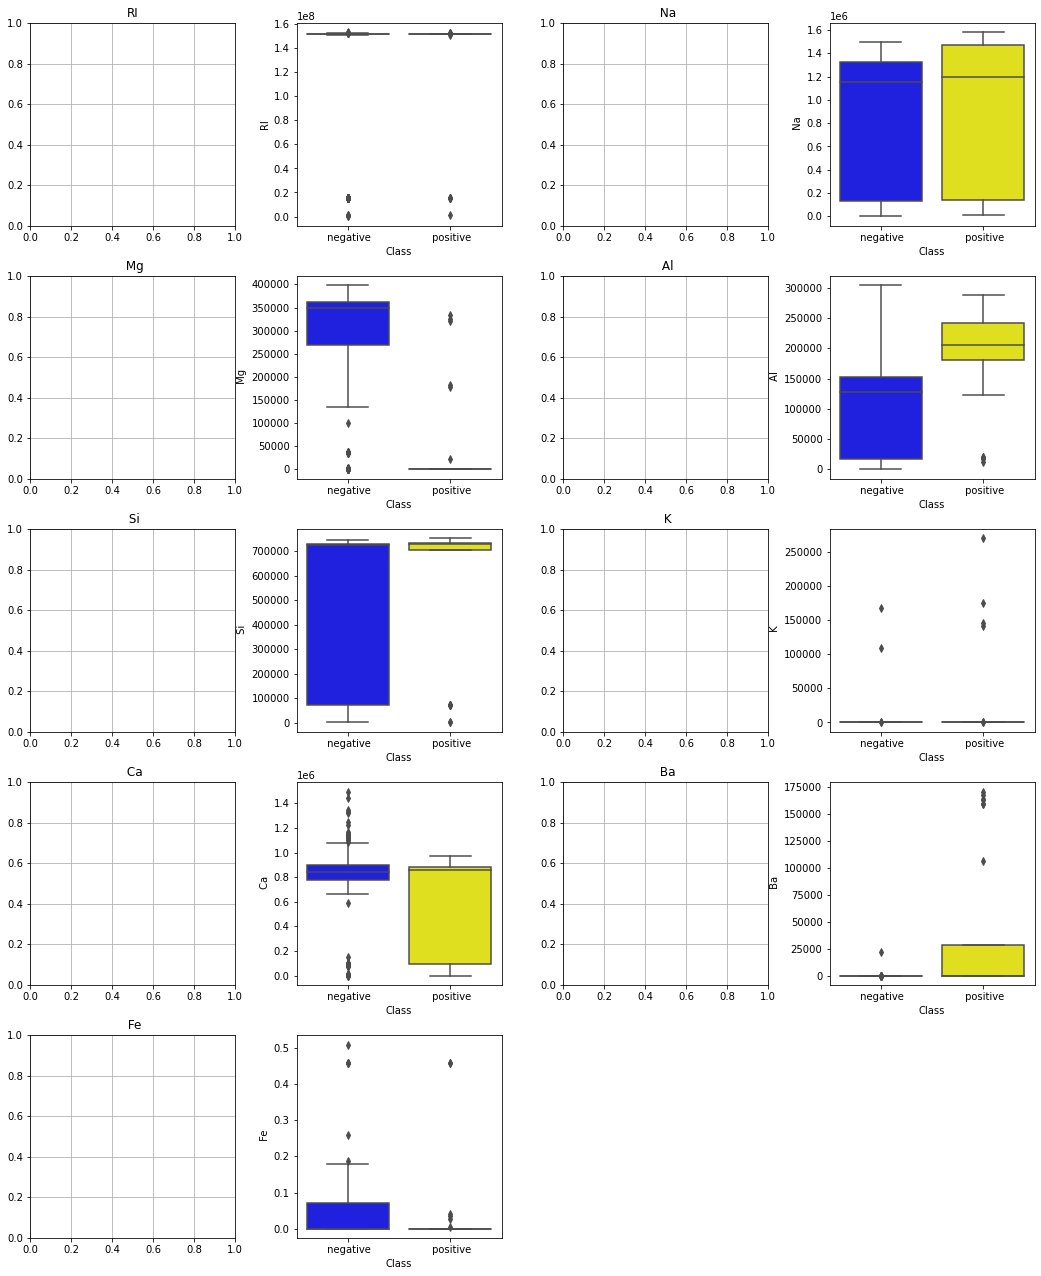

In [5]:
features = data_train.iloc[:,:9].columns.tolist()
plt.figure(figsize=(18, 27))

for i, col in enumerate(features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(data_train.loc[data_train["Class"]=='negative', col], label="alive", color = "blue", shade=True, cut=0)
    sns.kdeplot(data_train.loc[data_train["Class"]=='positive', col], label="dead",  color = "yellow", shade=True,  cut=0)

    plt.subplot(6, 4, i*2+2) 
    sns.boxplot(y = col, data = data_train, x="Class", palette = ["blue", "yellow"]) 

In [6]:
label_train = data_train.iloc[:,-1].to_numpy()
fitur_train = data_train.iloc[:,:9].to_numpy()

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(fitur_train)
fitur_train_normalize = scaler.transform(fitur_train)

# LMKNN

As i said before, the basic concept of the LMKNN classifier is to compute local mean vectors of k nearest neighbors from each class to classify the query sample. The difference between the KNN and the LMKNN in the k parameter. If in the KNN algorithm, the k-value is the number of closest neighbors, but in the LMKNN, it is the k the nearest neighbors of each class. I try to visualization the difference concept of KNN and LMKNN in this figure below.

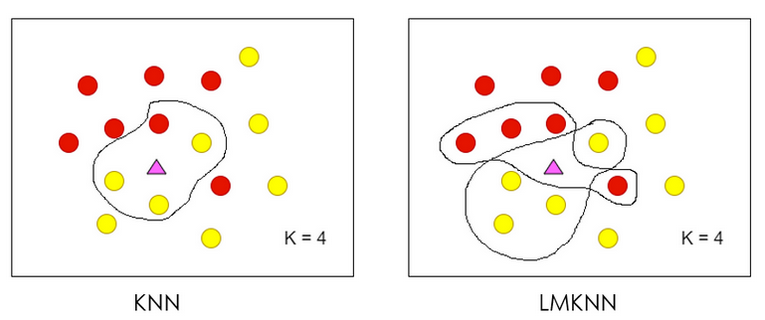

I used Euclidean to calculate the distance metrics.

In [8]:
import scipy.spatial
import numpy as np
from operator import itemgetter
from collections import Counter

class LMKNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def distance(self, X1, X2):
      return scipy.spatial.distance.euclidean(X1, X2)
    
    def predict(self, X_test):
        final_output = []
        myclass = list(set(self.y_train))
        for i in range(len(X_test)):
            eucDist = []
            votes = []
            for j in range(len(X_train)):
                dist = scipy.spatial.distance.euclidean(X_train[j] , X_test[i])
                eucDist.append([dist, j, self.y_train[j]])
            eucDist.sort()
            
            minimum_dist_per_class = []
            for c in myclass:
              minimum_class = []
              for di in range(len(eucDist)):
                if(len(minimum_class) != self.k):
                  if(eucDist[di][2] == c):
                    minimum_class.append(eucDist[di])
                else:
                  break
              minimum_dist_per_class.append(minimum_class)
           
            indexData = []
            for a in range(len(minimum_dist_per_class)):
              temp_index = []
              for j in range(len(minimum_dist_per_class[a])):
                temp_index.append(minimum_dist_per_class[a][j][1])
              indexData.append(temp_index)

            centroid = []
            for a in range(len(indexData)):
              transposeData = X_train[indexData[a]].T
              tempCentroid = []
              for j in range(len(transposeData)):
                tempCentroid.append(np.mean(transposeData[j]))
              centroid.append(tempCentroid)
            centroid = np.array(centroid)
           
            eucDist_final = []
            for b in range(len(centroid)):
              dist = scipy.spatial.distance.euclidean(centroid[b] , X_test[i])
              eucDist_final.append([dist, myclass[b]])
            sorted_eucDist_final = sorted(eucDist_final, key=itemgetter(0))
            final_output.append(sorted_eucDist_final[0][1])
        return final_output
    
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        value = 0
        for i in range(len(y_test)):
          if(predictions[i] == y_test[i]):
            value += 1
        return value / len(y_test)

To generalization the performance of LMKNN, i used k-fold cross validation with 10-fold

In [9]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=1, shuffle=True) 
kf.get_n_splits(fitur_train_normalize)

10

In [10]:
acc_LMKNN = [] 
for train_index, test_index in kf.split(fitur_train_normalize):
  lmknn = LMKNN(3)
  X_train, X_test = fitur_train_normalize[train_index], fitur_train_normalize[test_index]
  y_train, y_test = label_train[train_index], label_train[test_index]

  lmknn.fit(X_train, y_train) 
  result = lmknn.score(X_test, y_test)
  acc_LMKNN.append(result)
print('LMKNN : ',acc_LMKNN)
print('Mean :', np.mean(acc_LMKNN))

LMKNN :  [1.0, 0.9090909090909091, 0.8181818181818182, 0.9090909090909091, 0.7142857142857143, 0.9523809523809523, 1.0, 0.9523809523809523, 0.9523809523809523, 0.9523809523809523]
Mean : 0.9160173160173161


# Comparision with KNN

In [11]:
import scipy.spatial
from collections import Counter

class KNN:
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def distance(self, X1, X2):
        return scipy.spatial.distance.euclidean(X1, X2)
    
    def predict(self, X_test):
        final_output = []
        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(X_train)):
                dist = scipy.spatial.distance.euclidean(X_train[j] , X_test[i])
                d.append([dist, j])
            d.sort()
            
            d = d[0:self.k]
            for d, j in d:
                votes.append(self.y_train[j])
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)
            
        return final_output
    
    def score(self, X_test, y_test):
      predictions = self.predict(X_test)
      value = 0
      for i in range(len(y_test)):
        if(predictions[i] == y_test[i]):
          value += 1
      return value / len(y_test)

I used the same data and parameters

In [12]:
acc_KNN = [] 
for train_index, test_index in kf.split(fitur_train_normalize):
  knn = KNN(3)
  X_train, X_test = fitur_train_normalize[train_index], fitur_train_normalize[test_index]
  y_train, y_test = label_train[train_index], label_train[test_index]

  knn.fit(X_train,y_train)
  prediction = knn.score(X_test, y_test)
  acc_KNN.append(prediction)
print('KNN : ', acc_KNN)
print('Mean :', np.mean(acc_KNN))

KNN :  [0.9090909090909091, 0.9090909090909091, 0.7727272727272727, 0.8636363636363636, 0.8095238095238095, 0.8571428571428571, 0.9523809523809523, 0.9047619047619048, 0.8571428571428571, 0.8571428571428571]
Mean : 0.8692640692640692


# Result

The experimental result shows that the LMKNN method got the highest overall average classification accuracy of 91,6%. %. This shows that the LMKNN can overcome the problem of outliers and class imbalance with better performance compared to KNN algorithms 

# References

[1] S. Mehta, X. Shen, J. Gou, and D. Niu, “A new nearest centroid neighbor classifier based on k local means using harmonic mean distance,” Inf., vol. 9, no. 9, 2018, doi: 10.3390/info9090234